## 0. Import Packages

In [17]:
import numpy as np
from numpy import pi as π
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import firedrake
from firedrake import Constant, inner, sqrt, tr, grad, div, as_vector, exp,sym, as_vector, dx, ds, Mesh, Function
import meshpy, meshpy.geometry, meshpy.triangle
import irksome
from irksome import Dt
from scipy.signal import detrend
import copy
import matplotlib
import irksome
from irksome import Dt
import matplotlib.pyplot as plt

## 1. Create the initial mesh

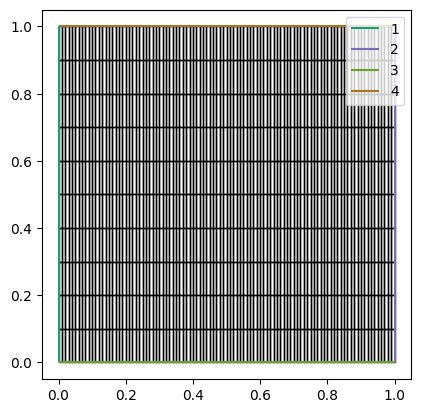

In [18]:
#Creating the initial mesh dimensions

nx, nz = 100, 10
initial_mesh = firedrake.UnitSquareMesh(nx, nz, quadrilateral=True)

fig, ax = plt.subplots()
ax.set_aspect("equal")
firedrake.triplot(initial_mesh, axes=ax)
ax.legend();

### 1.1 Create a more reaslistic mesh

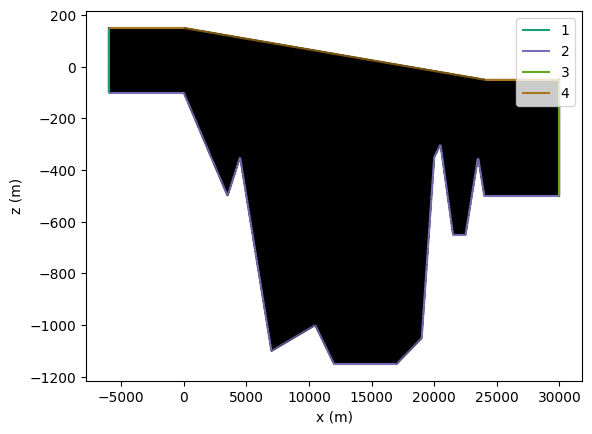

In [19]:
x, z = firedrake.SpatialCoordinate(initial_mesh)

# Input the mesh dimensions here, not sure how to do this automatically
depth = 1150
height_max = 150
height_min = -50
length = 24000

slope = (height_max - height_min) / length

mesh = Mesh('immersed_domain_AH_Kerhl_fixed_boundary.msh')
x, z = firedrake.SpatialCoordinate(mesh)

surface_id = [4]
left_id = [1]
bed_id = [2]
right_id = [3]

fig, ax = plt.subplots()
ax.set_aspect("auto")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
firedrake.triplot(mesh, axes=ax)
# ax.set_ylim([-100,100])
# ax.set_xlim([0,500])
ax.set_aspect("auto")
ax.legend();


### 2. Constants

In [20]:
# Constants
spy = 365.25 * 24 * 60 * 60
ρ = Constant(917.0)    # kg / m^3
c = Constant(2180)     # J / kg C
k = Constant(2.22)  # W / m C
α = (k/(ρ*c)) # diffusivity
A = 3.5e-25 
n = 3
R = 8.31446261815324
act_vol = -1.74e-5
Q = 6e4 # activatyion energy J/mol

dTdz = 2e-2 #C per 100m
geo_flux = Constant(46e-3) #W/m^2

λ = Constant(10.0)    # m
grav = Constant(-9.81) #m/s^2

vel_mpy = Constant(0.50) #m/yr
vel = vel_mpy / spy

# Surface condition
T_mean = -31 #average temp (C)
T_surface = Constant(T_mean) #

### 3. Build the pressure and velocity space

In [21]:

element = firedrake.FiniteElement("CG", "quadrilateral", 1)
V = firedrake.FunctionSpace(mesh, element)

T = firedrake.Function(V)
ϕ = firedrake.TestFunction(V)

In [22]:
pressure_space = firedrake.FunctionSpace(mesh, "CG", 1)
velocity_space = firedrake.VectorFunctionSpace(mesh, "CG", 2)
Y = velocity_space * pressure_space

y = firedrake.Function(Y)
u, p = firedrake.split(y)


μ = Constant(5e15) #Ice
# μ = Constant(1e14) #Test
def ε(u):
    return sym(grad(u))

v, q = firedrake.TestFunctions(y.function_space())

τ = 2 * μ * ε(u)
g = as_vector((0, grav))
f =  ρ * g

F_momentum = (inner(τ, ε(v)) - q * div(u) - p * div(v) - inner(f, v)) * dx

### 3.1 Boundary conditions

In [23]:
accum = Constant(0.05 / spy)


velocity_profile_r = (0.05/spy) * (1-((z/500))**(n+1)) #What is this velocity?
velocity_profile_z = - accum * ((1+(z/depth))**(n+1))
velocity_profile_surf = - accum * (1-(x/length/2))

bc_l = firedrake.DirichletBC(Y.sub(0), as_vector((0, velocity_profile_z)), left_id) 
bc_b = firedrake.DirichletBC(Y.sub(0), as_vector((0, 0)), bed_id) 

bc_r = firedrake.DirichletBC(Y.sub(0), as_vector((velocity_profile_r, 0)), right_id) 
#bc_r = firedrake.DirichletBC(Y.sub(0), as_vector((0, 0)), right_id) 
# bc_s = firedrake.DirichletBC(Y.sub(0), as_vector((0, velocity_profile_surf)), [3]) # Not working

# bc_l = firedrake.DirichletBC(Y.sub(0), as_vector((velocity_profile, 0)), [1]) 
bc=[bc_l, bc_b, bc_r]


### 4. Building the stokes solver

In [24]:
basis = firedrake.VectorSpaceBasis(constant=True, comm=firedrake.COMM_WORLD)
nullspace = firedrake.MixedVectorSpaceBasis(Y, [Y.sub(0), basis])

stokes_problem = firedrake.NonlinearVariationalProblem(F_momentum, y, bc)
parameters = {
    "nullspace": nullspace,
    "solver_parameters": {
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}
stokes_solver = firedrake.NonlinearVariationalSolver(stokes_problem, **parameters)

stokes_solver.solve()

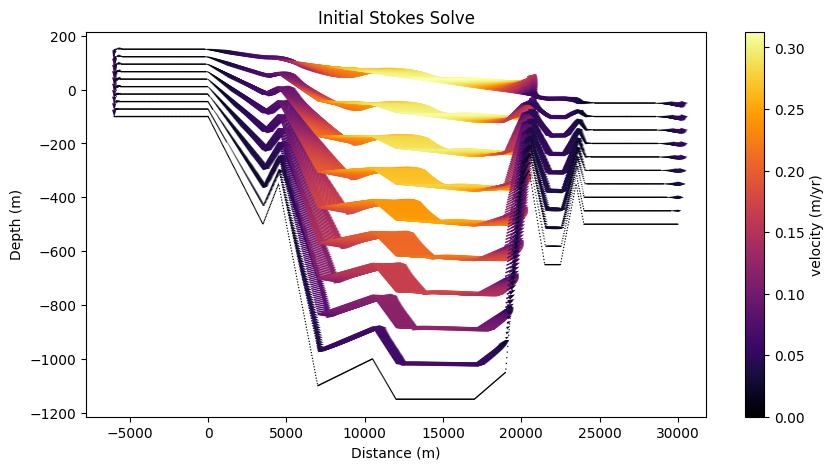

In [25]:
fig, axes = plt.subplots(figsize = [10,5])
vel_field_plot = firedrake.quiver(y.sub(0)*spy, axes=axes, cmap="inferno", scale=3);
fig.colorbar(vel_field_plot, label='velocity (m/yr)')
axes.set_ylabel('Depth (m)')
axes.set_xlabel('Distance (m)')
axes.set_title('Initial Stokes Solve')
# axes.set_xlim([9000,10000])
# axes.set_ylim([-1200,-800])
plt.show()
# fig.savefig('Test_model_flowfield.png')

### 5. Temperature

### 5.1 Just diffusion

In [26]:
geothermal_flux = -geo_flux*ϕ  * ds((bed_id[0]))

F = k * inner(grad(T), grad(ϕ)) * dx + geothermal_flux

# surf_bc = firedrake.DirichletBC(V, T_surface, surf_ids)
surf_bc = firedrake.DirichletBC(V, T_surface+(slope / (1/100))*(1 + (x/length)), surface_id) #slope / (1/100) term is the dry adiabat following the slope

bcs = [surf_bc]

firedrake.solve(F == 0, T, bcs)

### 5.2 Diffusion and advection

### 5.2.1 Construct the boundary conditions

In [27]:
upper_bc_init = firedrake.DirichletBC(V, T_surface+((height_max - height_min) / 100)*(x/length), surface_id)
left_bc_init = firedrake.DirichletBC(V, -31 + ((-z/depth)*0.024), left_id)

bcs_init = [left_bc_init, upper_bc_init]

upper_bc_init = firedrake.DirichletBC(V, -31, surface_id)
bcs_init = [upper_bc_init]

In [28]:
F_diffusion = k*inner(grad(T), grad(ϕ)) * dx
F_advection = - ρ * c * T * inner(u, grad(ϕ)) * dx

F_0 = F_advection + F_diffusion + geothermal_flux


firedrake.solve(F_0 == 0, T, bcs_init)

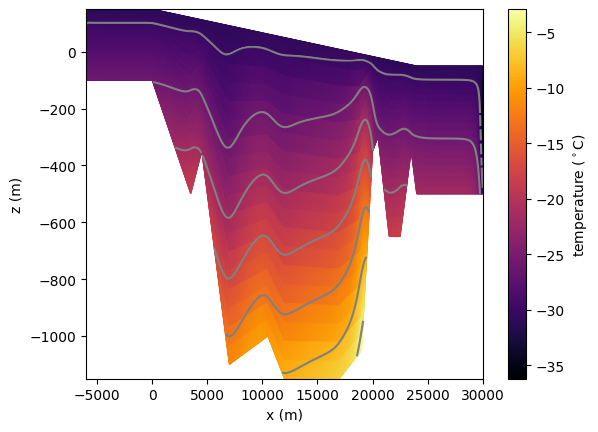

In [29]:
fig, ax = plt.subplots()
ax.set_aspect("auto")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
colors = firedrake.tripcolor(T, cmap="inferno", axes=ax)
fig.colorbar(colors, label="temperature (${}^\circ$C)")
levels = np.linspace(-30, 0, 8)
firedrake.tricontour(T, levels=levels, colors="grey", axes=ax)
# ax.set_xlim([9000,10000]);

### 5.3 New A parameter

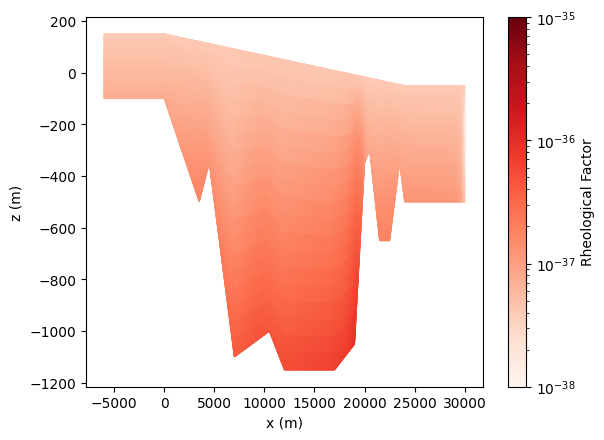

In [30]:

A_new = A*exp(-((Q + (p*act_vol))/((T+273.15)*R)))
A_new_field = Function(V).project(A_new)

fig, ax = plt.subplots()
ax.set_aspect("auto")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
colors = firedrake.tripcolor(A_new_field, cmap="Reds", axes=ax, norm=matplotlib.colors.LogNorm(vmin=1e-38, vmax=1e-35))
fig.colorbar(colors, label='Rheological Factor')

### 6. Calculate a new visocity and rate factor A

0.7436423718702008
0.002081608629619943


/tmp/ipykernel_1255/1901407109.py:105: RuntimeWarning: invalid value encountered in divide
  vx_normalized = vx / magnitudes
/tmp/ipykernel_1255/1901407109.py:106: RuntimeWarning: invalid value encountered in divide
  vy_normalized = vy / magnitudes


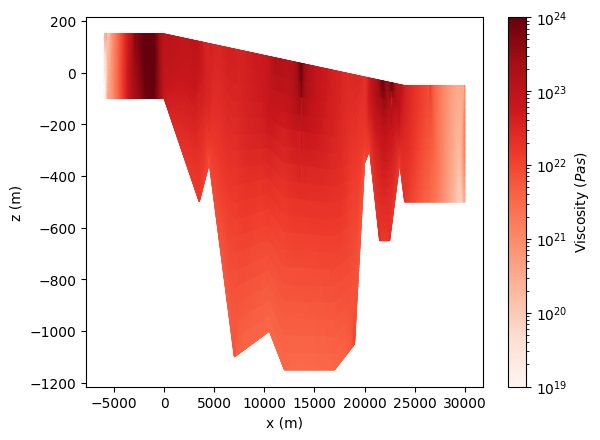

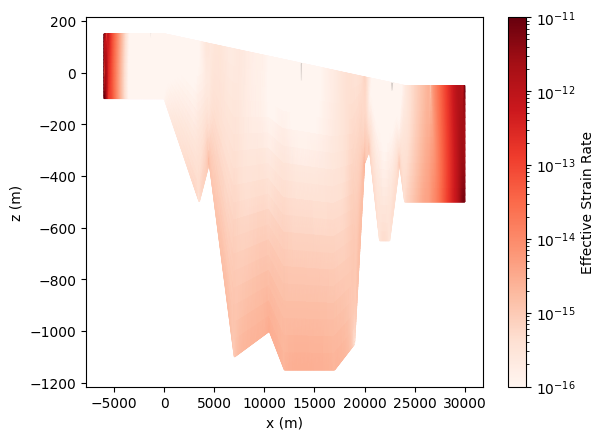

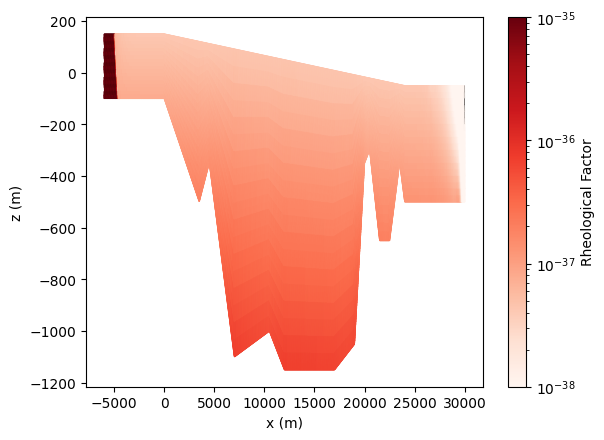

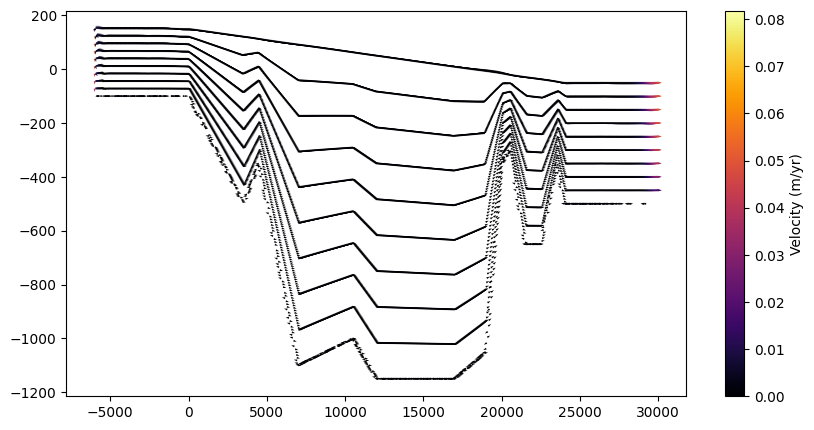

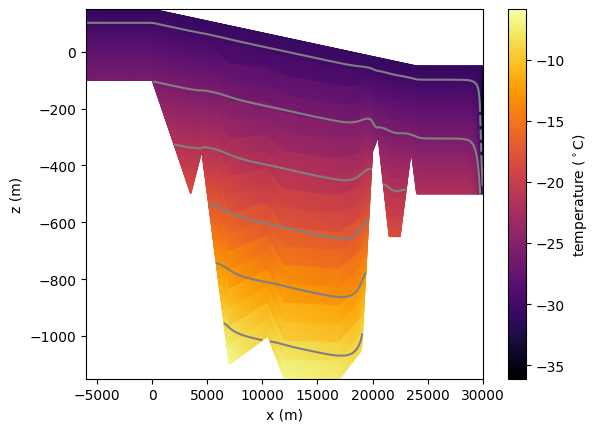

In [31]:
velocity_field = y.sub(0).dat.data
temp_field = T.dat.data

for i in range(100):
    prev_temp_field = copy.deepcopy(temp_field)
    prev_velocity = copy.deepcopy(velocity_field)
    ϵ_ = sym(grad(u))
    
    ϵ_effective = sqrt((inner(ϵ_, ϵ_)+tr(ϵ_)**2)*0.5)
    
    A_new = A*exp(-((Q + (p*act_vol))/((T+273.15)*R)))
    μ_new =  0.5*(A_new**(-1/n))*(ϵ_effective**((1/n)-1))
    
    μ_new_field = Function(V).project(μ_new)
    ϵ_effective_field = Function(V).project(ϵ_effective)
    A_new_field = Function(V).project(A_new)

    def ε(u):
        return sym(grad(u))
    
    ### Build the stokes flow model ###
    
    pressure_space = firedrake.FunctionSpace(mesh, "CG", 1)
    velocity_space = firedrake.VectorFunctionSpace(mesh, "CG", 2)
    Y = velocity_space * pressure_space
    
    y = firedrake.Function(Y)
    u, p = firedrake.split(y)
    v, q = firedrake.TestFunctions(y.function_space())
    
    τ = 2* μ_new * ε(u)#  2 * μ_new_field *  ϵ_
    g = as_vector((0, grav))
    f =  ρ * g
    
    F_momentum = (inner(τ, ε(v)) - q * div(u) - p * div(v) - inner(f, v)) * dx

    basis = firedrake.VectorSpaceBasis(constant=True, comm=firedrake.COMM_WORLD)
    nullspace = firedrake.MixedVectorSpaceBasis(Y, [Y.sub(0), basis])

    stokes_problem = firedrake.NonlinearVariationalProblem(F_momentum, y, bc)
    parameters = {
        "nullspace": nullspace,
        "solver_parameters": {
            "ksp_type": "preonly",
            "pc_type": "lu",
            "pc_factor_mat_solver_type": "mumps",
        },
    }
    stokes_solver = firedrake.NonlinearVariationalSolver(stokes_problem, **parameters)

    stokes_solver.solve()

    
    ### Get the new velocity field solved for ###
    velocity_field = y.sub(0).dat.data


    
    ### Build the temperature model ###
    
    F_diffusion = k*inner(grad(T), grad(ϕ)) * dx
    F_advection = - ρ * c * T * inner(u, grad(ϕ)) * dx
    geothermal_flux = -geo_flux*ϕ  * ds((bed_id[0]))
 
    F_0 = F_advection + F_diffusion + geothermal_flux

    ### Solve for the temperature field
    firedrake.solve(F_0 == 0, T, bcs_init)

    ### Get the new temp field we just solved for ###
    temp_field = T.dat.data

    ### Calculate the residuals in the temp field ###
    residual = np.sum(np.abs((prev_temp_field - temp_field)))/temp_field.shape[0]
    print(residual)
    if residual < 0.01: #If the residual is less than the 0.01 m/yr, let's call it good.
        fig, ax = plt.subplots()
        ax.set_aspect("auto")
        ax.set_xlabel("x (m)")
        ax.set_ylabel("z (m)")
        colors = firedrake.tripcolor(μ_new_field, cmap="Reds", axes=ax,  norm=matplotlib.colors.LogNorm(vmin=1e19, vmax=1e24))
        fig.colorbar(colors, label='Viscosity ($Pa s$)')

        fig, ax = plt.subplots()
        ax.set_aspect("auto")
        ax.set_xlabel("x (m)")
        ax.set_ylabel("z (m)")
        colors = firedrake.tripcolor(ϵ_effective_field, cmap="Reds", axes=ax, norm=matplotlib.colors.LogNorm(vmin=1e-16,vmax=1e-11))
        fig.colorbar(colors, label='Effective Strain Rate')
        
        fig, ax = plt.subplots()
        ax.set_aspect("auto")
        ax.set_xlabel("x (m)")
        ax.set_ylabel("z (m)")
        colors = firedrake.tripcolor(A_new_field, cmap="Reds", axes=ax, norm=matplotlib.colors.LogNorm(vmin=1e-38, vmax=1e-35))
        fig.colorbar(colors, label='Rheological Factor')
        # Extract the vector field components and coordinates
        x_ex, y_ex = mesh.coordinates.dat.data.T
        # Interpolate the vector field at mesh vertices
        vx = np.array([y.sub(0).at([x_ex[i], y_ex[i]])[0] for i in range(len(x_ex))])
        vy = np.array([y.sub(0).at([x_ex[i], y_ex[i]])[1] for i in range(len(y_ex))])
        
        # Compute magnitudes and normalize vectors to have unit length
        magnitudes = np.sqrt(vx**2 + vy**2)
        vx_normalized = vx / magnitudes
        vy_normalized = vy / magnitudes
        fig, axes = plt.subplots(figsize = [10,5])
        vel_plot = plt.quiver(x_ex, y_ex, vx_normalized, vy_normalized, magnitudes*spy,cmap="inferno") # Adjust 'scale' as needed for visibility
        plt.colorbar(vel_plot, label="Velocity (m/yr)")

        fig, ax = plt.subplots()
        ax.set_aspect("auto")
        ax.set_xlabel("x (m)")
        ax.set_ylabel("z (m)")
        colors = firedrake.tripcolor(T, cmap="inferno", axes=ax)
        fig.colorbar(colors, label="temperature (${}^\circ$C)")
        levels = np.linspace(-30, 0, 8)
        firedrake.tricontour(T, levels=levels, colors="grey", axes=ax)
        # ax.set_xlim([9000,10000]);
        break
